# Overview #

## Project Info ##

- Developed by: Sean Pritchard
- for: CSCA 5642: Introduction to Deep Learning
- URL: https://github.com/seanpritchard94/cancer-detection
- Data Source: https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview (Cukierski, 2018)
- Python version: 3.13

## Data Collection and Provenance ##

The data is a subset of the PatchCamelyon (PCam) dataset.

> The PatchCamelyon benchmark is a new and challenging image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue. PCam provides a new benchmark for machine learning models: bigger than CIFAR10, smaller than imagenet, trainable on a single GPU. (Veeling, 2018)

The subset of data was curated and provided as a kaggel competition. (Cukierski, 2018) We will use the Kaggle Subset of data.

A few important notes about the Kaggle subset include:

> A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image. (Cukierski, 2018)

> The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark. (Cukierski, 2018)

## Deep Learning Problem Description ##

**Type of Learning and Task:** This is a **binary image classification** deep learning problem. I will build a **Convolutional Neural Network** deep learning model capable of classifying the images in the data set

**Project Goal:** Build a deep learning model capable of classifying the images with **at least 90% validation accuracy**.

## Data Description ##

The data is provided as a labeled training set and an unlabeled test set for submission to the Kaggle competition. The data consists of images in the TIFF format. The images have 3 layers (R,G.B) and are 96x96 pixels in size. There are 220,025 images in the labeled training set and 57,458 images in the unlabeled test set.



In [1]:
#import various libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tifffile
import pathlib
import gc
from sklearn.model_selection import train_test_split

%matplotlib inline

# Exploratory Data Analysis, Visualization, and Cleaning #

## Data Loading ##
We will start by loading the labels and then load each image according to the order of the labels. This will keep the images and labels in sync.

The next three cells are related to running in the Google Collab environment. To run this locally, point DRIVE_PATH to the data directory.



In [2]:
from google.colab import drive
drive.mount('/content/drive')
#DRIVE_PATH = '/content/drive/My Drive/data/cancer_detection'


Mounted at /content/drive


In [5]:
#copy file fro google drive and unzip
!cp '/content/drive/My Drive/data/histopathologic-cancer-detection.zip' '/content/'


In [6]:
!rm -rf '/content/data/'
!unzip -q '/content/histopathologic-cancer-detection.zip' -d '/content/data/'

In [7]:
DRIVE_PATH = '/content/data'

In [8]:
train_labels_df = pd.read_csv(f'{DRIVE_PATH}/train_labels.csv')
train_labels_df.head(10)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


In [9]:
y_complete = train_labels_df["label"].values
print(y_complete[:10])

[0 1 0 0 0 0 1 1 0 0]


In [10]:
X = []
y = []

for index, row in train_labels_df.iterrows():
    file_id = row['id']
    label = row['label']
    file_name = f'{DRIVE_PATH}/train/{file_id}.tif'

    # Check if the file exists before attempting to read it
    if pathlib.Path(file_name).is_file():
        try:
            img = tifffile.imread(file_name)
            X.append(img)
            y.append(label) # Append label only if image is successfully loaded
        except Exception as e:
            print(f"Error reading file {file_name}: {e}")
    else:
        print(f"File not found: {file_name}")


print(f'len(X): {len(X)}, len(y): {len(y)}')


len(X): 220025, len(y): 220025



## EDA and Visualization ##


In [11]:
def increment_dict(my_dict, my_value):
    if my_dict.get(my_value) is None:
        my_dict[my_value] = 1
    else:
        my_dict[my_value] += 1

layers = {}
width = {}
height = {}
#We need to understand the format of these images. How many layers?
for img_array in X:
    my_shape = img_array.shape
    increment_dict(height, my_shape[0])
    increment_dict(width, my_shape[1])
    increment_dict(layers, my_shape[2])

print(f'height: {height}, width: {width}, layers: {layers}')

height: {96: 220025}, width: {96: 220025}, layers: {3: 220025}


In [12]:
def show_image(img_array, id, label):
    plt.imshow(img_array)
    plt.title(f"Image: {id} - Label: {label}")
    plt.axis('off') # Hide axes for cleaner display
    plt.show()

def show_images(label, count):
    shown = 0
    for i in range(len(y)):
        if y[i] == label:
            shown += 1
            show_image(X[i], train_labels_df.loc[i, 'id'], y[i])
        if shown == count:
            break


**We will display the first three positive label images**

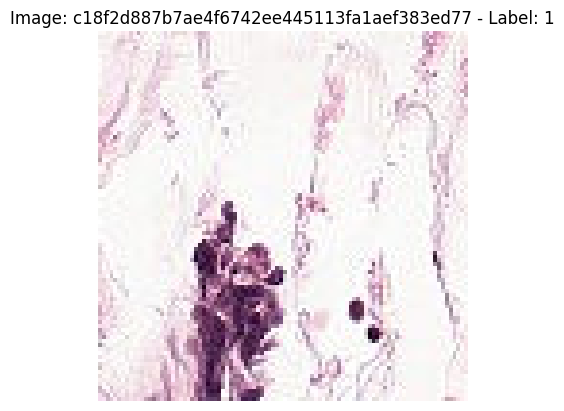

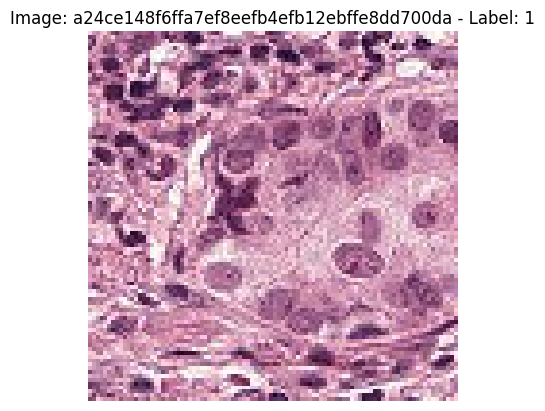

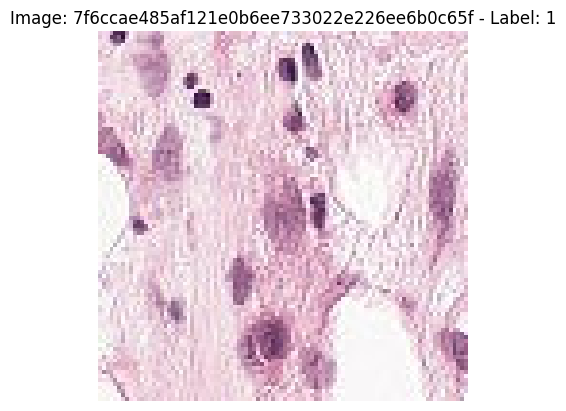

In [13]:
show_images(1, 3)

**And the first three negative label images**

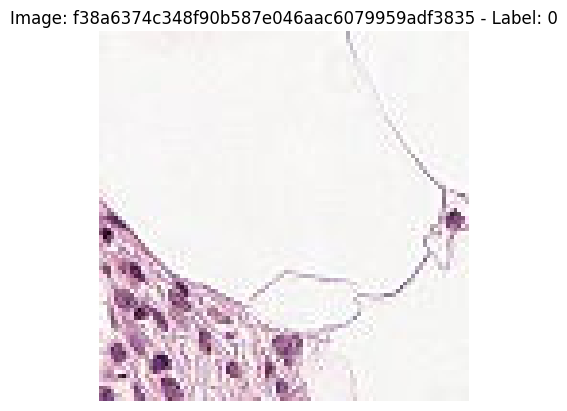

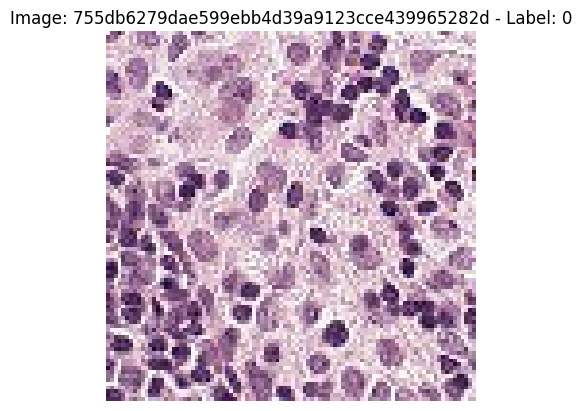

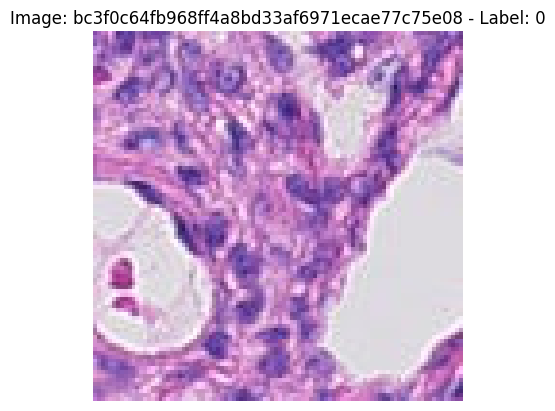

In [14]:
show_images(0, 3)

### Class Distribution ###

As we see below, the **classes are imbalanced** with the ratio of class 0 to class 1 being approximately 3 to 2.


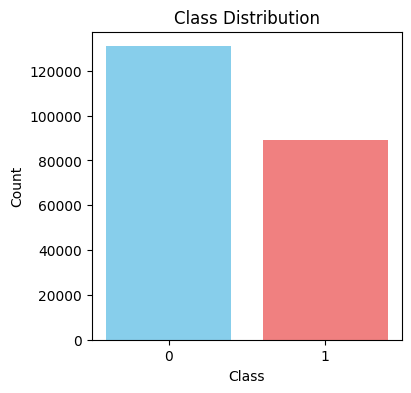

In [15]:
class_0_count = 0
class_1_count = 0

for label in y:
    if label == 0:
        class_0_count += 1
    else:
        class_1_count += 1

plt.figure(figsize=(4, 4))
plt.bar(['0','1'], [class_0_count, class_1_count], color=['skyblue', 'lightcoral'])
plt.title('Class Distribution')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

### Distribution of Average and Standard Deviation for RGB ###
Let's examine the distribution of average and standard deviation of pixel values in the three layers (R,G,B)


In [16]:
class_0_r_avgs = []
class_0_g_avgs = []
class_0_b_avgs = []
class_1_r_avgs = []
class_1_g_avgs = []
class_1_b_avgs = []

class_0_r_stds = []
class_0_g_stds = []
class_0_b_stds = []
class_1_r_stds = []
class_1_g_stds = []
class_1_b_stds = []

def avg_per_layer(img_array):
    """"
    returns the average value of the R, G. B layers
    for an image
    """
    return np.mean(img_array, axis=(0,1))

def std_per_layer(img_array):
    """"
    returns the standard deviation value of the R, G. B layers
    for an image
    """
    return np.std(img_array, axis=(0,1))


for i in range(len(X)):
    img_array = X[i]
    label = y[i]
    r_avg, g_avg, b_avg = avg_per_layer(img_array)
    r_std, g_std, b_std = std_per_layer(img_array)
    if label == 0:
        class_0_r_avgs.append(r_avg)
        class_0_b_avgs.append(b_avg)
        class_0_g_avgs.append(g_avg)
        class_0_r_stds.append(r_std)
        class_0_b_stds.append(b_std)
        class_0_g_stds.append(g_std)
    else:
        class_1_r_avgs.append(r_avg)
        class_1_b_avgs.append(b_avg)
        class_1_g_avgs.append(g_avg)
        class_1_r_stds.append(r_std)
        class_1_b_stds.append(b_std)
        class_1_g_stds.append(g_std)


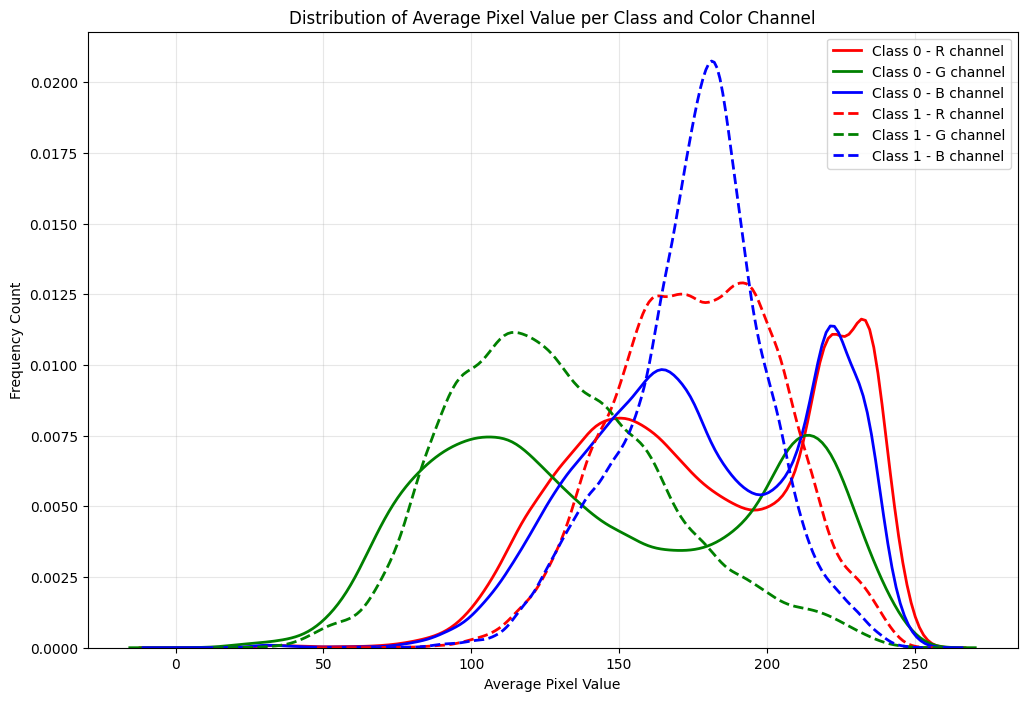

In [17]:
plt.figure(figsize=(12, 8))
sns.kdeplot(class_0_r_avgs, label='Class 0 - R channel', color='red', linestyle='-', linewidth=2)
sns.kdeplot(class_0_g_avgs, label='Class 0 - G channel', color='green', linestyle='-', linewidth=2)
sns.kdeplot(class_0_b_avgs, label='Class 0 - B channel', color='blue', linestyle='-', linewidth=2)
sns.kdeplot(class_1_r_avgs, label='Class 1 - R channel', color='red', linestyle='--', linewidth=2)
sns.kdeplot(class_1_g_avgs, label='Class 1 - G channel', color='green', linestyle='--', linewidth=2)
sns.kdeplot(class_1_b_avgs, label='Class 1 - B channel', color='blue', linestyle='--', linewidth=2)
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency Count')
plt.title('Distribution of Average Pixel Value per Class and Color Channel')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

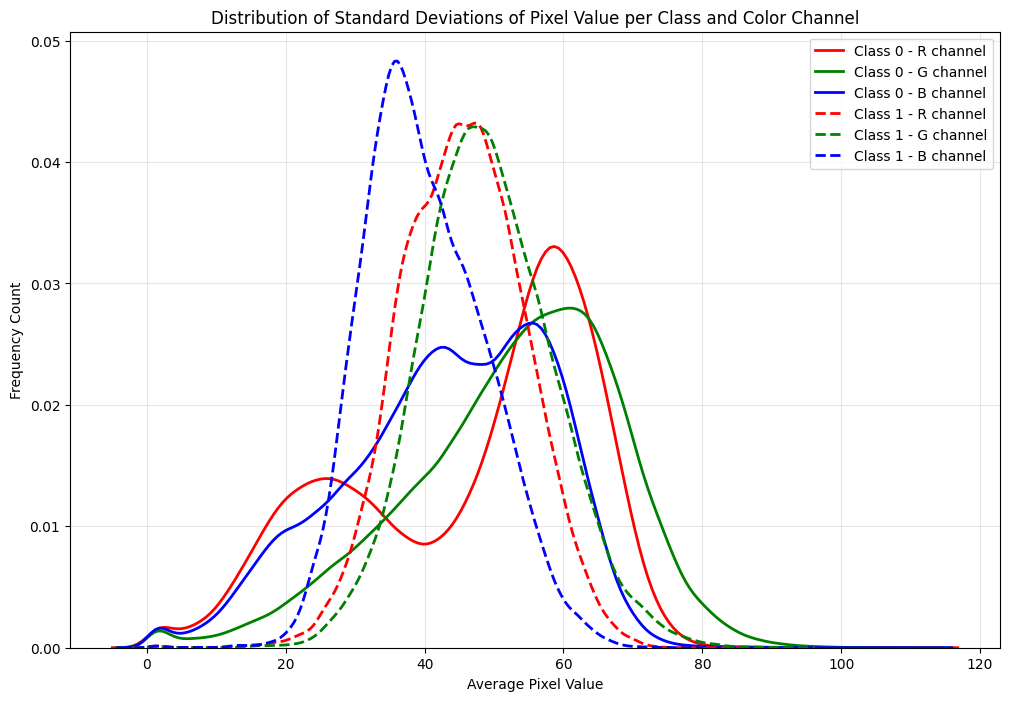

In [18]:
plt.figure(figsize=(12, 8))
sns.kdeplot(class_0_r_stds, label='Class 0 - R channel', color='red', linestyle='-', linewidth=2)
sns.kdeplot(class_0_g_stds, label='Class 0 - G channel', color='green', linestyle='-', linewidth=2)
sns.kdeplot(class_0_b_stds, label='Class 0 - B channel', color='blue', linestyle='-', linewidth=2)
sns.kdeplot(class_1_r_stds, label='Class 1 - R channel', color='red', linestyle='--', linewidth=2)
sns.kdeplot(class_1_g_stds, label='Class 1 - G channel', color='green', linestyle='--', linewidth=2)
sns.kdeplot(class_1_b_stds, label='Class 1 - B channel', color='blue', linestyle='--', linewidth=2)
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency Count')
plt.title('Distribution of Standard Deviations of Pixel Value per Class and Color Channel')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Data Cleaning ##
### Outlier Detection and Removal ###

We will create box plot to visualize outliers.

<Figure size 1600x700 with 0 Axes>

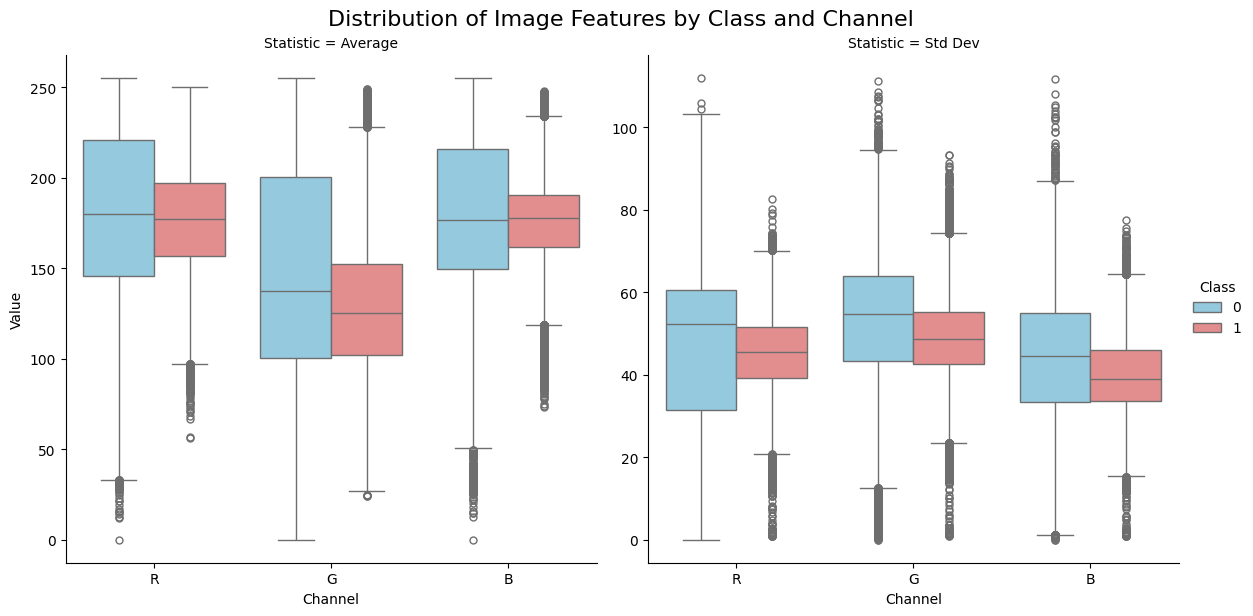

In [19]:
# Determine the length of the sample lists for easier calculation
len_c0 = len(class_0_r_avgs)
len_c1 = len(class_1_r_avgs)
total_len = (len_c0 + len_c1) * 3

# Combine Averages
data_avg = {
    'Value': class_0_r_avgs + class_0_g_avgs + class_0_b_avgs +
             class_1_r_avgs + class_1_g_avgs + class_1_b_avgs,
    'Channel': (['R'] * len_c0) + (['G'] * len_c0) + (['B'] * len_c0) +
               (['R'] * len_c1) + (['G'] * len_c1) + (['B'] * len_c1),
    'Class': ([0] * (len_c0 * 3)) + ([1] * (len_c1 * 3)),
    'Statistic': ['Average'] * total_len
}
df_avg = pd.DataFrame(data_avg)

# Combine Standard Deviations
data_std = {
    'Value': class_0_r_stds + class_0_g_stds + class_0_b_stds +
             class_1_r_stds + class_1_g_stds + class_1_b_stds,
    'Channel': data_avg['Channel'],
    'Class': data_avg['Class'],
    'Statistic': ['Std Dev'] * total_len
}
df_std = pd.DataFrame(data_std)

df_combined = pd.concat([df_avg, df_std])

plt.figure(figsize=(16, 7))

# Use seaborn's catplot for a faceted grid of box plots
sns.catplot(data=df_combined, x='Channel', y='Value', hue='Class',
    col='Statistic', kind='box', palette=['skyblue', 'lightcoral'],
    sharey=False, height=6, aspect=1)

plt.suptitle('Distribution of Image Features by Class and Channel', y=1.02, fontsize=16)
plt.show()


**These boxplots confirm we have outliers.**

### IQR Outlier Detection ###

Then we will use the **Interquartile Range (IQR) method**, which is "one of the most robust and widely used techniques for detecting outliers — especially in skewed distributions." (More, 2025)


In [21]:
data_c0 = {
    'R_Avg': class_0_r_avgs, 'G_Avg': class_0_g_avgs, 'B_Avg': class_0_b_avgs,
    'R_Std': class_0_r_stds, 'G_Std': class_0_g_stds, 'B_Std': class_0_b_stds,
    'Class': 0
}
df_c0 = pd.DataFrame(data_c0)

data_c1 = {
    'R_Avg': class_1_r_avgs, 'G_Avg': class_1_g_avgs, 'B_Avg': class_1_b_avgs,
    'R_Std': class_1_r_stds, 'G_Std': class_1_g_stds, 'B_Std': class_1_b_stds,
    'Class': 1
}
df_c1 = pd.DataFrame(data_c1)

df_features = pd.concat([df_c0, df_c1], ignore_index=True)

def find_iqr_outliers(df, feature_name):
    """
    Calculates IQR bounds and returns a boolean Series indicating outliers.
    """
    #Calculate Q1, Q3, and IQR
    Q1 = df[feature_name].quantile(0.25)
    Q3 = df[feature_name].quantile(0.75)
    IQR = Q3 - Q1
    #Define Bounds (1.5 * IQR)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    #Return a boolean Series where True indicates an outlier
    return (df[feature_name] < lower_bound) | (df[feature_name] > upper_bound)

df_outliers = pd.DataFrame(index=df_features.index)

feature_columns = ['R_Avg', 'G_Avg', 'B_Avg', 'R_Std', 'G_Std', 'B_Std']

for class_label in [0, 1]:

    df_class = df_features[df_features['Class'] == class_label]

    for feature in feature_columns:
        # Generate a unique column name for the flag (e.g., 'R_Avg_C0_Outlier')
        flag_col = f'{feature}_C{class_label}_Outlier'

        # Calculate flags and assign them back to the main df_outliers
        df_outliers.loc[df_class.index, flag_col] = find_iqr_outliers(df_class, feature)

pd.set_option('future.no_silent_downcasting', True)
df_outliers = df_outliers.fillna(False)

#Outliers in AVG Features (R_Avg, G_Avg, B_Avg)
avg_outlier_flags = df_outliers[[col for col in df_outliers.columns if 'Avg' in col]]
avg_outlier_count = avg_outlier_flags.sum(axis=1)

#Outliers in STD DEV Features (R_Std, G_Std, B_Std)
std_outlier_flags = df_outliers[[col for col in df_outliers.columns if 'Std' in col]]
std_outlier_count = std_outlier_flags.sum(axis=1)

# Total number of features flagged as an outlier for each image (max of 6)
total_outlier_count = avg_outlier_count + std_outlier_count

# Outliers in ONLY ONE channel/feature
single_feature_outliers = (total_outlier_count == 1).sum()

# Outliers in ALL THREE CHANNELS (Avg and Std separately)
all_avg_outliers = (avg_outlier_count == 3).sum()
all_std_outliers = (std_outlier_count == 3).sum()

# Outlier in ALL SIX features (R,G,B Avg AND R,G,B Std)
all_six_features_outliers = (total_outlier_count == 6).sum()


print("IQR Outlier Summary")
print(f"Total Images Analyzed: {len(df_features)}")

print("Outliers based on Total Flags (Avg + Std Dev)")
print(f"Images flagged as outlier in ONLY ONE feature (outlier count = 1): {single_feature_outliers}")
print(f"Images flagged as outlier in ALL SIX features (outlier count = 6): {all_six_features_outliers}")

print("Outliers based on Average Features Only")
print(f"Images flagged as outlier in ALL THREE AVERAGE features (R, G, and B): {all_avg_outliers}")

print("Outliers based on STD Features Only")
print(f"Images flagged as outlier in ALL THREE STD features (R, G, and B): {all_std_outliers}")

total_images_with_outliers = (total_outlier_count > 0).sum()
print(f"Total Images flagged as outlier in AT LEAST ONE feature: {total_images_with_outliers}")

IQR Outlier Summary
Total Images Analyzed: 220025
Outliers based on Total Flags (Avg + Std Dev)
Images flagged as outlier in ONLY ONE feature (outlier count = 1): 3426
Images flagged as outlier in ALL SIX features (outlier count = 6): 0
Outliers based on Average Features Only
Images flagged as outlier in ALL THREE AVERAGE features (R, G, and B): 4
Outliers based on STD Features Only
Images flagged as outlier in ALL THREE STD features (R, G, and B): 182
Total Images flagged as outlier in AT LEAST ONE feature: 4609


**Only ~2%** of the data contained and outlier. We will **remove all images containing outliers** from the training data set.

In [22]:
indices_to_keep = total_outlier_count[total_outlier_count == 0].index.tolist()
X_cleaned = [X[i] for i in indices_to_keep]
y_cleaned = [y[i] for i in indices_to_keep]

print(f'X_cleaned: {len(X_cleaned)}, y_cleaned: {len(y_cleaned)}')

X_cleaned: 215416, y_cleaned: 215416


### Sampling and Normalizing the Data ###

The data set is too large to conduct hyperparameter tuning on the entire set, so I will select a subset of 15,000 random samples and then, we will normalize it to a range of 0-1 (rather than the current 0-255).  Because the data set is **imbalanced,** we will **undersample** from the majority class to achieve a balanced data set. We will also extract a validation set from the training data for use in monitoring model training.

For final training on the entire data set, we will use a data generator approach and normalize as the data is loaded.

Now split a **subset** of the data into **training and validation** sets for hyperparameter tuning

In [23]:
from imblearn.under_sampling import RandomUnderSampler

# Convert to NumPy array for consistency, then delete the source structure.
X_cleaned_np = np.array(X_cleaned)

print(f"Initial shape: {X_cleaned_np.shape}, dtype: {X_cleaned_np.dtype}")

#We will start by taking a random subsample of 20K,
#then we will use RandomUnderSampler to balance the classes
SUBSET_SIZE = 15000
subset_ratio = SUBSET_SIZE / len(X_cleaned_np)

# Use train_test_split on the uint8 data to get the stratified subset.
# The 'test' output will be our 15,000-sample subset.
X_junk, X_subset_all, y_junk, y_subset_all = train_test_split(
    X_cleaned_np, y_cleaned,
    test_size=subset_ratio,
    random_state=42,
    stratify=y_cleaned,
    shuffle=True
)

print(f'X_subset_all: {len(X_subset_all)}, y_subset_all: {len(y_subset_all)}')

n_samples = X_subset_all.shape[0]

#the X data has to be flattened before resampling
X_subset_2d = X_subset_all.reshape(n_samples, -1)

print(f"Flattened X shape: {X_subset_2d.shape}")

rus = RandomUnderSampler(random_state=42)
# Use the new 2D array for resampling
X_resampled_2d, y_resampled = rus.fit_resample(X_subset_2d, y_subset_all)

print(f'X_resampled_2d: {len(X_resampled_2d)}, y_resampled: {len(y_resampled)}')

#Reshape back to (96, 96, 3)
X_resampled = X_resampled_2d.reshape(-1, 96, 96, 3)

# normalize only the small subset to float32.
# converting from uint8 to float32 is expensive in terms of RAM usage
X_resampled = np.divide(X_resampled, 255.0, dtype=np.float32)

print(f'X_resampled: {len(X_resampled)}, y_resampled: {len(y_resampled)}')

# split the small, normalized subset into train/val splits for tuning.
X_subset, X_val, y_subset, y_val = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f'X_subset: {len(X_subset)}, X_val: {len(X_val)}, y_subset: : {len(y_subset)}, y_val: : {len(y_val)}')


Initial shape: (215416, 96, 96, 3), dtype: uint8
X_subset_all: 15000, y_subset_all: 15000
Flattened X shape: (15000, 27648)
X_resampled_2d: 12152, y_resampled: 12152
X_resampled: 12152, y_resampled: 12152
X_subset: 9721, X_val: 2431, y_subset: : 9721, y_val: : 2431


In [ ]:
#clean up unused data

#DO NOT delete indices_to_keep we need that later

del class_0_r_avgs
del class_0_g_avgs
del class_0_b_avgs
del class_1_r_avgs
del class_1_g_avgs
del class_1_b_avgs

del class_0_r_stds
del class_0_g_stds
del class_0_b_stds
del class_1_r_stds
del class_1_g_stds
del class_1_b_stds

del data_avg
del df_avg
del data_std
del df_std
del df_combined

del data_c0
del df_c0
del data_c1
del df_c1
del df_features

del df_outliers
del avg_outlier_flags
del avg_outlier_count
del std_outlier_flags
del std_outlier_count
del total_outlier_count
del single_feature_outliers
del all_avg_outliers
del all_std_outliers
del all_six_features_outliers

del X, train_labels_df

del X_resampled
del X_subset_all
del y_subset_all

del X_subset_2d
del X_resampled_2d
del X_cleaned
del X_cleaned_np
del X_junk
del y_junk

gc.collect()


# Analysis (Model Building and Training) #

I will create an initial architecture (architecture 1) and then conduct hyperparameter tuning. The results of that tuning will influence architecture 2, architecture 3, etc.

## Plan of Analysis ##

Because the data documentation indicates that the label is based on the central 32x32 pixels, we will use a Keras cropping layer at the beginning to focus our model's attention. We will increase our number of filters with each iteration because "Increasing the number of feature maps can help the network learn more complex and abstract features." (Baeldung, 2023)

**Architecture 1:**
- Crop to 32x32
- Convolution, Convolution, MaxPool pattern repeated 4 times
- padding = same because we already cropped the image
- filter depth: 32, 64, 128, 256
- Dense Hidden Layers: 128, 64, 32, 16, 8
- Filter Size: 3x3
- Pooling: Max
- Hidden Layers: Relu
- Output: Sigmoid

In initial testing, Architecture 1 was found to **perform poorly**, so architecture 2 attempts to address that by **removing the cropping layer**. It may be that many tumors lay on the boundary of the central 32x32 pixels and cropping made it difficult to identify them.

**Architecture 2:**
- NO Cropping
- Convolution, Convolution, MaxPool pattern repeated 4 times
- padding = same
- filter depth: 32, 64, 128, 256
- Dense Hidden Layers: 128, 64, 32, 16, 8
- Filter Size: 3x3
- Pooling: Max
- Hidden Layers: Relu
- Output: Sigmoid

Archtecture 2 **performed better, but below expectations**. **Adding dropout and normalization can help** (Litjens, 2019), so I will try that for architecture 3. I have also simplified the Dense layers to minimize overfitting

**Architecture 3:**
- No Cropping
- Convolution, Convolution, MaxPool, BatchNormalization, Dropout pattern repeated 4 times
- padding = same
- filter depth: 32, 64, 128, 256
- Dense Hidden Layers: 128, 64, Dropout between the dense layers
- Hidden Layers: Relu
- Output: Sigmoid

Architecture 3 performed well on the small training sample but badly overfit the complete data sample. Architecture 4 is the result of hyperparameter and model tuning on the entire data set, which was quite slow and expensive in GPU time. The most significant change in architecture 4 is the reduction of the Dense layers to a single smaller layer with regularization.

**Architecture 4:**
- No Cropping
- Convolution, Convolution, BatchNormalization, MaxPool, Dropout pattern repeated 4 times
- padding = same
- filter depth: 32, 64, 128, 256
- **Single** Dense Hidden Layers: 32,
- Dropout after dense layer, L2 regularization to minimize overfitting
- Hidden Layers: Relu
- Output: Sigmoid

HyperParameters:
- Learning rate: 0.01, 0.001, 0.0001
- Epochs: 20, 50 (I want to keep these shorter during the grid search for hyperparameters)
- Optimization Method: Adam, RMSProp
- dropout rate: (added for architecture 2) 0.3, 0.4, 0.5

I expect architecture 1 will do well because the repeated pattern of Convolution, Convolution, Max Pooling has shown to perform well on image classification tasks.

I expect architecture 2 to reduce overfitting

I expect architecture 3 to improve accuracy without increasing overfitting

Architecture 4 ended up doing well on the full data set. The main difference was the aggressive reduction of the Dense layers at the end down to a single layer of 32 with L2 regularization. This was required to prevent significant overfitting that happened with the more complicated dense layers.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow.keras as keras # Need for optimizer definition
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

def create_architecture_1(input_shape=(96, 96, 3), initial_filters=32, learning_rate=0.001, optimizer_name='Adam'):
    """
    Creates architecture 1
    """
    model = models.Sequential()

    #Cropping the 96x96 image down to the central 32x32 region.
    model.add(layers.Cropping2D(cropping=((32, 32), (32, 32)), input_shape=input_shape))
    filters = initial_filters
    for i in range(4): # Loop 4 times (Conv, Conv, MaxPool
        # Increase filters: 32, 64, 128, 256
        filters = (i+1)*initial_filters
        # Conv2D Layer 1: 3x3, Relu, padding='same' (maintains size before pooling)
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        # Conv2D Layer 2: 3x3, Relu, padding='same'
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        # MaxPool2D Layer
        model.add(layers.MaxPool2D(pool_size=(2, 2)))
    # Classifier Head
    model.add(layers.Flatten())
    # Dense Hidden Layers: 128, 64, 32, 16, 8 (all Relu)
    for units in [128, 64, 32, 16, 8]:
        model.add(layers.Dense(units, activation='relu'))
    # Output Layer: 1 unit, Sigmoid
    model.add(layers.Dense(1, activation='sigmoid'))

    # Define the optimizer based on the hyperparameter search
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'RMSProp':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Compile the model for binary classification
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def create_architecture_2(input_shape=(96, 96, 3), initial_filters=32, learning_rate=0.001, optimizer_name='Adam', dropout_rate=0.3):
    """
    Creates architecture 2
    """
    model = models.Sequential()

    #NO Cropping
    filters = initial_filters
    for i in range(4): # Loop 4 times (Conv, Conv, MaxPool
        # Increase filters: 32, 64, 128, 256
        filters = (i+1)*initial_filters
        # Conv2D Layer 1: 3x3, Relu, padding='same' (maintains size before pooling)
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        # Conv2D Layer 2: 3x3, Relu, padding='same'
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        # MaxPool2D Layer
        model.add(layers.MaxPool2D(pool_size=(2, 2)))
    # Classifier Head
    model.add(layers.Flatten())
    # Dense Hidden Layers: 128, 64, 32, 16, 8 (all Relu)
    for units in [128, 64, 32, 16, 8]:
        model.add(layers.Dense(units, activation='relu'))
    # Output Layer: 1 unit, Sigmoid
    model.add(layers.Dense(1, activation='sigmoid'))

    # Define the optimizer based on the hyperparameter search
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'RMSProp':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Compile the model for binary classification
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def create_architecture_3(input_shape=(96, 96, 3), initial_filters=32, learning_rate=0.001, optimizer_name='Adam', dropout_rate=0.3):
    """
    Creates architecture 3
    """
    model = models.Sequential()
    filters = initial_filters
    for i in range(4):  # 4 Conv blocks
        filters = (i + 1) * initial_filters

        # First Conv + BN + ReLU
        model.add(layers.Conv2D(filters, (3, 3), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())

        # Second Conv + BN + ReLU
        model.add(layers.Conv2D(filters, (3, 3), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())

        # Pooling and Dropout
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        if i >= 1:  # light dropout after deeper blocks
            model.add(layers.Dropout(dropout_rate))

    # Global Average Pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D())

    # Simpler Dense head
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Optimizer selection
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'RMSProp':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Compile
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def create_architecture_4(input_shape=(96, 96, 3), initial_filters=32, learning_rate=0.001, optimizer_name='Adam', dropout_rate=0.3):
    """
    Creates architecture 4
    """
    model = models.Sequential()
    filters = initial_filters
    for i in range(4):  # 4 Conv blocks
        filters = (i + 1) * initial_filters

        # First Conv + BN + ReLU
        model.add(layers.Conv2D(filters, (3, 3), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())

        # Second Conv + BN + ReLU
        model.add(layers.Conv2D(filters, (3, 3), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())

        # Pooling and Dropout
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        if i >= 1:  # light dropout after deeper blocks
            model.add(layers.Dropout(dropout_rate))

    # Global Average Pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D())

    # Simpler Dense head
    model.add(layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Optimizer selection
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'RMSProp':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Compile
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def create_model(model_name, input_shape=(96, 96, 3), learning_rate=0.001, optimizer_name='Adam', dropout_rate=0.3):
    if model_name == 'architecture_1':
        return create_architecture_1(input_shape=input_shape, learning_rate=learning_rate, optimizer_name=optimizer_name)
    elif model_name == 'architecture_2':
        return create_architecture_2(input_shape=input_shape, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout_rate=dropout_rate)
    elif model_name == 'architecture_3':
        return create_architecture_3(input_shape=input_shape, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout_rate=dropout_rate)
    elif model_name == 'architecture_4':
        return create_architecture_4(input_shape=input_shape, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout_rate=dropout_rate)
    else:
      raise ValueError(f"Unknown model name: {model_name}")


def hyperparameter_grid_search(model_name, hyperparameter_grid, X_subset_tensor,
                               y_subset_tensor, X_val_tensor, y_val_tensor, batch_size=64):

    print(f"Starting Hyperparameter Search on a training subset of {len(X_subset)} images.")
    results = []
    #Run the Grid Search Loop
    for lr in hyperparameter_grid['learning_rate']:
        for optimizer in hyperparameter_grid['optimizer_name']:
            for epochs in hyperparameter_grid['epochs']:
                for dropout_rate in hyperparameter_grid['dropout_rate']:

                    print(f"Running Trial: LR={lr}, Opt={optimizer}, Epochs={epochs}, dropout_rate={dropout_rate}")

                    #ensure each run starts clean
                    tf.keras.backend.clear_session()

                    model = create_model(
                        model_name=model_name,
                        input_shape=X_subset.shape[1:],
                        learning_rate=lr,
                        optimizer_name=optimizer,
                        dropout_rate=dropout_rate
                    )

                    #stop early when we stop improving val loss
                    early_stop_callback = EarlyStopping(
                        monitor='val_loss',
                        patience=5,
                        restore_best_weights=True
                    )

                    history = model.fit(
                        X_subset_tensor, y_subset_tensor,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val_tensor, y_val_tensor),
                        verbose=2,
                        callbacks=[early_stop_callback]
                    )

                    final_loss = history.history['val_loss'][-1]
                    final_acc = history.history['val_accuracy'][-1]

                    results.append({
                        'learning_rate': lr,
                        'optimizer': optimizer,
                        'epochs': epochs,
                        'dropout_rate': dropout_rate,
                        'val_loss': final_loss,
                        'val_accuracy': final_acc
                    })


    results_df = pd.DataFrame(results).sort_values(by='val_loss')
    print("Hyperparameter Search Complete")
    print(results_df)


# Results and Analysis #

## Hyperparameter Tuning ##

Execute hyperparameter tuning with Grid Search on Architecture 1

In [ ]:
BATCH_SIZE = 64

#convert to tensors to avoid keras error
X_subset_tensor = tf.convert_to_tensor(X_subset, dtype=tf.float32)
y_subset_tensor = tf.convert_to_tensor(y_subset, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)



In [ ]:
# The full list of hyperparameter combinations for the tuning phase
HYPERPARAM_GRID = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'optimizer_name': ['Adam', 'RMSProp'],
    'epochs': [50],
    'dropout_rate': [0.0]
}

#hyperparameter tuning for architecture 1
hyperparameter_grid_search(model_name='architecture_1',
                           hyperparameter_grid=HYPERPARAM_GRID,
                           X_subset_tensor=X_subset_tensor,
                           y_subset_tensor=y_subset_tensor,
                           X_val_tensor=X_val_tensor,
                           y_val_tensor=y_val_tensor,
                           batch_size=BATCH_SIZE)


Starting Hyperparameter Search on a training subset of 9721 images.
Running Trial: LR=0.01, Opt=Adam, Epochs=50, dropout_rate=0.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/cropping2d.py:57: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
152/152 - 25s - 164ms/step - accuracy: 0.5006 - loss: 1.2636 - val_accuracy: 0.4912 - val_loss: 0.6933
Epoch 2/50
152/152 - 1s - 7ms/step - accuracy: 0.5019 - loss: 0.6932 - val_accuracy: 0.5088 - val_loss: 0.6930
Epoch 3/50
152/152 - 1s - 7ms/step - accuracy: 0.4950 - loss: 0.6933 - val_accuracy: 0.4912 - val_loss: 0.6935
Epoch 4/50
152/152 - 1s - 7ms/step - accuracy: 0.5006 - loss: 0.6933 - val_accuracy: 0.4912 - val_loss: 0.6940
Epoch 5/50
152/152 - 1s - 7ms/step - accuracy: 0.4940 - loss: 0.6935 - val_accuracy: 0.4912 - val_loss: 0.6934
Epoch 6/50
152/152 - 1s - 7ms/step - accuracy: 0.4958 - loss: 0.6934 - val_accuracy: 0.4912 - val_loss: 0.6938
Epoch 7/50
152/152 - 1s - 7ms/step - accuracy: 0.4936 - loss: 0.6934 - val_accuracy: 0.5088 - val_loss: 0.6931
Running Trial: LR=0.01, Opt=RMSProp, Epochs=50, dropout_rate=0.0
Epoch 1/50
152/152 - 11s - 73ms/step - accuracy: 0.4952 - loss: 0.6935 - val_accuracy: 0.4912 - val_loss: 0.6934
Epoch 2/50
152/152 - 1s - 7ms/step - accur

### Architecture 1 hyperparameter tuning analysis ###

The results indicate the **Adam with a learning rate of 0.0001** has the lowest validation loss and the highest validation accuracy.

However, I am not satisfied with less than 80% validation accuracy after 50 epochs, so I will try improving the model with architecture 2.

```
Hyperparameter Search Complete
   learning_rate optimizer  epochs  val_loss  val_accuracy
4         0.0001      Adam      50  0.449675      0.799260
3         0.0010   RMSProp      50  0.464353      0.784039
5         0.0001   RMSProp      50  0.485513      0.763883
0         0.0100      Adam      50  0.693128      0.508844
2         0.0010      Adam      50  0.693284      0.491156
1         0.0100   RMSProp      50  0.694738      0.491156
```

Even though we did not get the level of accuraccy we wanted, we did start to see **overfitting** in later epochs. At epoch 22, the accuracy and validation accuracy were very similar, but by epoch 29 we see meaningful divergence, and in fact, a reduction in validation accuracy.

```
Epoch 22/50
152/152 - 1s - 7ms/step - accuracy: 0.7932 - loss: 0.4528 - val_accuracy: 0.7931 - val_loss: 0.4544
...
Epoch 29/50
152/152 - 1s - 7ms/step - accuracy: 0.8162 - loss: 0.4141 - val_accuracy: 0.7795 - val_loss: 0.4816

```

### Hyperparameter search and tuning with architecture_2 ###
We will build on the results of architecture 1. Since we are trying to improve poor accuracy and we theorize this may be due to the cropping in architecture 1. We are also trying to reduce overfitting that happens at higher epoch numbers, so we will target 50 epochs. We will also focus only on the learning rates that showed promise

In [ ]:
HYPERPARAM_GRID = {
    'learning_rate': [0.001, 0.0001],
    'optimizer_name': ['Adam', 'RMSProp'],
    'epochs': [50],
    'dropout_rate': [0.0]
}

hyperparameter_grid_search(model_name='architecture_2',
                           hyperparameter_grid=HYPERPARAM_GRID,
                           X_subset_tensor=X_subset_tensor,
                           y_subset_tensor=y_subset_tensor,
                           X_val_tensor=X_val_tensor,
                           y_val_tensor=y_val_tensor,
                           batch_size=BATCH_SIZE)

Starting Hyperparameter Search on a training subset of 9721 images.
Running Trial: LR=0.001, Opt=Adam, Epochs=50, dropout_rate=0.0
Epoch 1/50
152/152 - 25s - 166ms/step - accuracy: 0.5050 - loss: 0.6932 - val_accuracy: 0.4912 - val_loss: 0.6934
Epoch 2/50
152/152 - 4s - 28ms/step - accuracy: 0.5022 - loss: 0.6933 - val_accuracy: 0.4912 - val_loss: 0.6933
Epoch 3/50
152/152 - 4s - 28ms/step - accuracy: 0.5010 - loss: 0.6932 - val_accuracy: 0.4912 - val_loss: 0.6932
Epoch 4/50
152/152 - 4s - 28ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accuracy: 0.4912 - val_loss: 0.6932
Epoch 5/50
152/152 - 4s - 28ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accuracy: 0.4912 - val_loss: 0.6932
Epoch 6/50
152/152 - 4s - 28ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accuracy: 0.4912 - val_loss: 0.6932
Epoch 7/50
152/152 - 4s - 28ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accuracy: 0.4912 - val_loss: 0.6932
Epoch 8/50
152/152 - 4s - 28ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accurac

### Architecture 2 hyperparameter tuning analysis. ###

Architecture 2 **improved validation accuracy** from 79% to 84%. This is a significant improvement.  Once again, Adam with a learning rate of 0.001 did best.

```
Hyperparameter Search Complete
   learning_rate optimizer  epochs  val_loss  val_accuracy
2         0.0001      Adam      50  0.346146      0.841629
3         0.0001   RMSProp      50  0.404670      0.815714
0         0.0010      Adam      50  0.693282      0.491156
1         0.0010   RMSProp      50  0.693283      0.491156
```

While this architecture performed better, we did not reach 90% validation accuracy and we started to overfit.

```
Epoch 25/50
152/152 - 4s - 29ms/step - accuracy: 0.8631 - loss: 0.3163 - val_accuracy: 0.8416 - val_loss: 0.3461
```

### Architecture 3 Hyperparamter Tuning ###

With architecture 3, we added batch normalizationn and dropout after each convolution layer and dropout after each hidden layer. The hope was to reduce overfitting and allow us to have more accuract genralizations

In [ ]:
HYPERPARAM_GRID = {
    'learning_rate': [0.001, 0.0001],
    'optimizer_name': ['Adam', 'RMSProp'],
    'epochs': [50],
    'dropout_rate': [0.2, 0.3, 0.4]
}

hyperparameter_grid_search(model_name='architecture_3',
                           hyperparameter_grid=HYPERPARAM_GRID,
                           X_subset_tensor=X_subset_tensor,
                           y_subset_tensor=y_subset_tensor,
                           X_val_tensor=X_val_tensor,
                           y_val_tensor=y_val_tensor,
                           batch_size=BATCH_SIZE)

Starting Hyperparameter Search on a training subset of 9721 images.
Running Trial: LR=0.001, Opt=Adam, Epochs=50, dropout_rate=0.2
Epoch 1/50
152/152 - 27s - 180ms/step - accuracy: 0.7946 - loss: 0.4590 - val_accuracy: 0.6092 - val_loss: 2.3833
Epoch 2/50
152/152 - 5s - 34ms/step - accuracy: 0.8409 - loss: 0.3733 - val_accuracy: 0.6109 - val_loss: 1.1665
Epoch 3/50
152/152 - 5s - 34ms/step - accuracy: 0.8461 - loss: 0.3630 - val_accuracy: 0.6047 - val_loss: 2.0009
Epoch 4/50
152/152 - 5s - 34ms/step - accuracy: 0.8514 - loss: 0.3465 - val_accuracy: 0.7071 - val_loss: 0.7591
Epoch 5/50
152/152 - 5s - 34ms/step - accuracy: 0.8605 - loss: 0.3258 - val_accuracy: 0.8482 - val_loss: 0.3278
Epoch 6/50
152/152 - 5s - 34ms/step - accuracy: 0.8714 - loss: 0.3133 - val_accuracy: 0.6828 - val_loss: 0.9602
Epoch 7/50
152/152 - 5s - 34ms/step - accuracy: 0.8778 - loss: 0.2930 - val_accuracy: 0.8482 - val_loss: 0.4203
Epoch 8/50
152/152 - 5s - 34ms/step - accuracy: 0.8809 - loss: 0.2851 - val_accurac

### Architecture 3 Hyperparameter search results ###

Once again, we got our best results with Adam and a learning rate of 0.0001. While we did not reach the 90% validation accuracy target, I anticipate improvements when we train on the entire data set.

```
Hyperparameter Search Complete
    learning_rate optimizer  epochs  dropout_rate  val_loss  val_accuracy
8          0.0001      Adam      50           0.4  0.313448      0.873715
1          0.0010      Adam      50           0.3  0.330732      0.872069
3          0.0010   RMSProp      50           0.2  0.339964      0.863842
2          0.0010      Adam      50           0.4  0.362912      0.848622
9          0.0001   RMSProp      50           0.2  0.377310      0.840395
10         0.0001   RMSProp      50           0.3  0.390758      0.846154
5          0.0010   RMSProp      50           0.4  0.393668      0.825998
7          0.0001      Adam      50           0.3  0.410928      0.826820
6          0.0001      Adam      50           0.2  0.421817      0.839161
11         0.0001   RMSProp      50           0.4  0.569069      0.795557
0          0.0010      Adam      50           0.2  0.869060      0.716166
4          0.0010   RMSProp      50           0.3  1.651479      0.649527
```



# Training on entire data set #

Before training on the entire data set, I will need to remove the outliers identified during EDA. I will also need to implement a Keras ImageDataGenerator so I can load and train on the data set incrementally because of the data size.

In [24]:
from collections import Counter

# Load the full data manifest
df_full = pd.read_csv('/content/data/train_labels.csv')
print(f"Total images loaded: {len(df_full)}")

df_clean = df_full.loc[indices_to_keep].reset_index(drop=True)

print(f"Outliers removed: {len(df_full) - len(df_clean)}")
print(f"Clean images remaining: {len(df_clean)}")

df_train, df_val = train_test_split(
    df_clean,
    test_size=0.20,
    random_state=42,
    stratify=df_clean['label']
)


X_train = df_train[['id']]
y_train = df_train['label']

print("\nBefore Undersampling:")
print(Counter(y_train))

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print("\nAfter Undersampling:")
print(Counter(y_resampled))

df_train_balanced = pd.DataFrame(X_resampled, columns=['id'])
df_train_balanced['label'] = y_resampled

df_train = df_train_balanced

# Convert labels to strings for the generator
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)

# Append the .tif extension to the 'id' column in both DataFrames
df_train['id'] = df_train['id'] + '.tif'
df_val['id'] = df_val['id'] + '.tif'

print(f"\nBalanced Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")


Total images loaded: 220025
Outliers removed: 4609
Clean images remaining: 215416

Before Undersampling:
Counter({0: 102525, 1: 69807})

After Undersampling:
Counter({0: 69807, 1: 69807})

Balanced Training set size: 139614
Validation set size: 43084


Using Keras **ImageDataGenerator** allow processing very large data sets in batches and also allows the application of various transformations such as rotation shifting horizontally or vertically, zooming, and flipping to make the model better able to handle such transformations. (Minhas, 2025)

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

TRAIN_DIR = '/content/data/train'
IMAGE_SIZE = 96
BATCH_SIZE = 64
SEED = 42

# Rescale=1./255 performs the 0-255 normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

#Validation data should only be scaled, not augmented.
val_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

# Validation Generator
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED
)

Found 139614 validated image filenames belonging to 2 classes.
Found 43084 validated image filenames belonging to 2 classes.


## Architecture 4 ##

When we tried running architecture 3 on the full data set we found it started overfitting almost immediately (within 1 or 2 epochs). It also fell far short of our goals of 90% validation accuracy. We tested a number of variations on architecture 3 until we found a model that performed well. We had to train on the full dataset over many epochs which was time-consuming and used many GPU credits.

The main difference in architecture 3 and 4 was a significant reduction in the Dense classification layers. We reduced it to a single layer of width 32 with L2 regularization. This finally solved the overfitting and allowed us to achieve the goal of 90% validation accuracy.

In [ ]:
#ensure we clean up before training the full model
tf.keras.backend.clear_session()
validation_generator.reset()
train_generator.reset()

#LR=0.0001, Opt=RMSProp dropout=0.3

full_model = create_model('architecture_4',
                          input_shape=(96, 96, 3),
                          learning_rate=0.0001,
                          optimizer_name='RMSProp',
                          dropout_rate=0.3)
#stop early when we stop improving val loss
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = full_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stop_callback]
)




Epoch 1/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 416s 186ms/step - accuracy: 0.8170 - loss: 0.4201 - val_accuracy: 0.8300 - val_loss: 0.4421
Epoch 2/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 396s 181ms/step - accuracy: 0.8692 - loss: 0.3173 - val_accuracy: 0.8637 - val_loss: 0.3385
Epoch 3/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 398s 182ms/step - accuracy: 0.8856 - loss: 0.2834 - val_accuracy: 0.8846 - val_loss: 0.3191
Epoch 4/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 400s 183ms/step - accuracy: 0.8963 - loss: 0.2643 - val_accuracy: 0.8829 - val_loss: 0.2979
Epoch 5/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 396s 181ms/step - accuracy: 0.9030 - loss: 0.2470 - val_accuracy: 0.9099 - val_loss: 0.2326
Epoch 6/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 399s 183ms/step - accuracy: 0.9081 - loss: 0.2378 - val_accuracy: 0.8998 - val_loss: 0.2635
Epoch 7/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 400s 183ms/step - accuracy: 0.9125 - loss: 0.2307 - val_accuracy: 0.8863 - val_loss: 0.3066
Epoch 8/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 399s 183ms/step - ac

In [ ]:
full_model.save('/content/drive/My Drive/data/cancer_detection.keras')

# Analysis #

From the very start, we faced two challenges: **low accuracy** combined with **overfitting**. The following graphs shows both factors in play with Architecture 1:



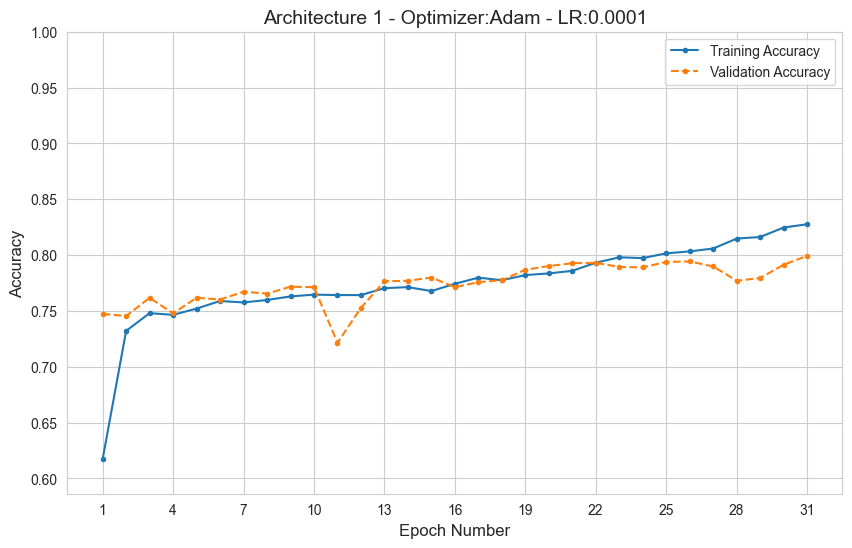

In [6]:
plot_arch_1()

For Archtecture 2, we eliminated the cropping layer on the theory that cropping was hurting accuracy. But we did not attempt to address overfitting. We saw a good improvement in validation accuracy on Architecture 2 (increased to 84% from 79%)




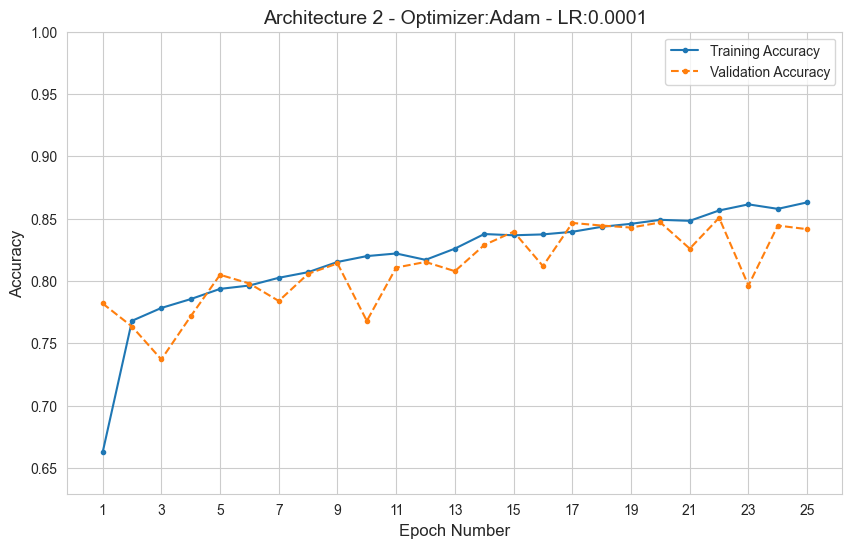

In [7]:
plot_arch_2()

For Architecture 3, we introduced Dropout and Batch Normalization and cut our number of Dense layers to 2. This resulted in continued improvements in validation accuracy.


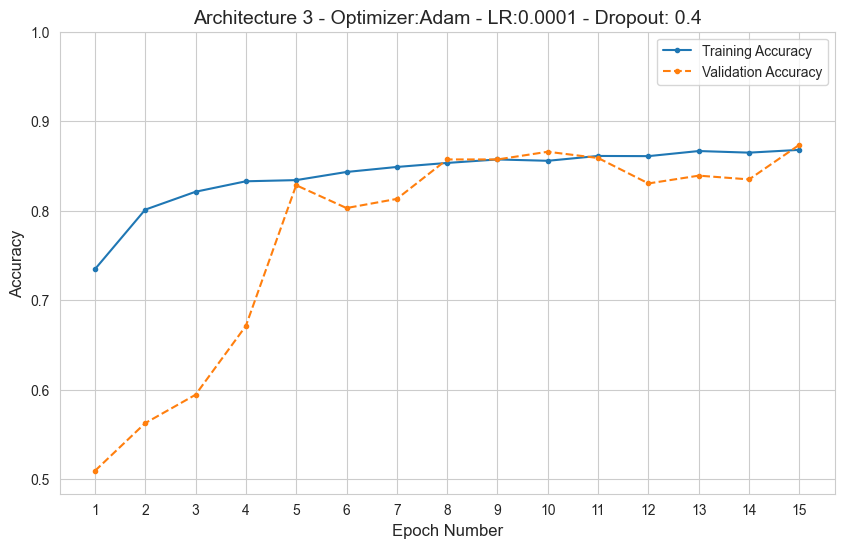

In [8]:
plot_arch_3()

I have plotted the best hyperparameters from each run above, but in some cases we had **extreme overfitting**. I offer this plot as an example. It is one example of many.

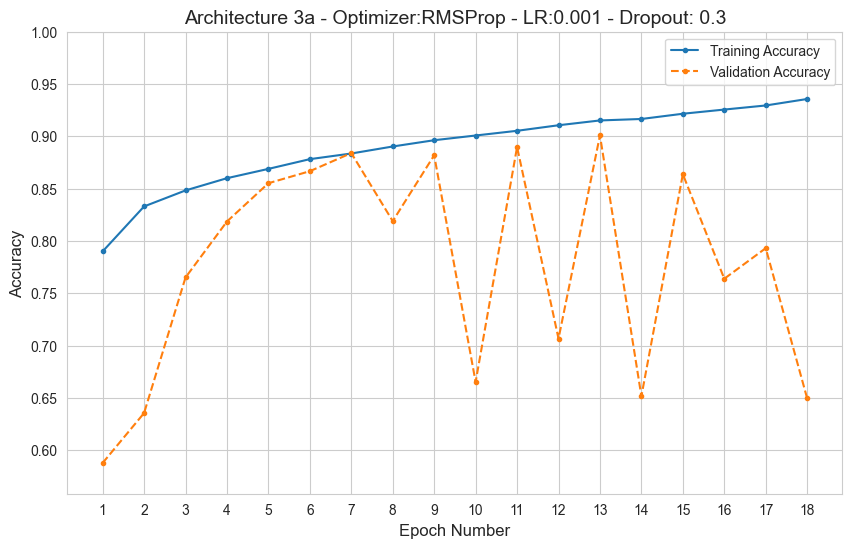

In [12]:
plot_arch_3_overfitting()

Moving to training on the complete data set, I quickly found that architecture 3 using the hyperparameter that had performed well on the entire data set resulted in **immediate and significant overfitting** (as much as **10% difference** in accuracy between train and validation data). As a result, I had to try various alternate architectures and hyperparameters on the whole data set.  Eventually, I settled on architecture 4. The main difference in architecture 3 and 4 was a significant reduction in the Dense classification layers. We reduced it to a single layer of width 32 with L2 regularization. This finally solved the overfitting and allowed us to achieve the goal of 90% validation accuracy.  Additionally, the best hyperparameters I found were learning_rate=0.0001, optimizer_name='RMSProp', and dropout_rate=0.3.

While Architecture 4 did start overfitting after epoch 9, I used **early stopping** and **restore best weights** to restore the model to the weights at epoch 9. This resulted in a model with approximately **92% training and validation accuracy!**


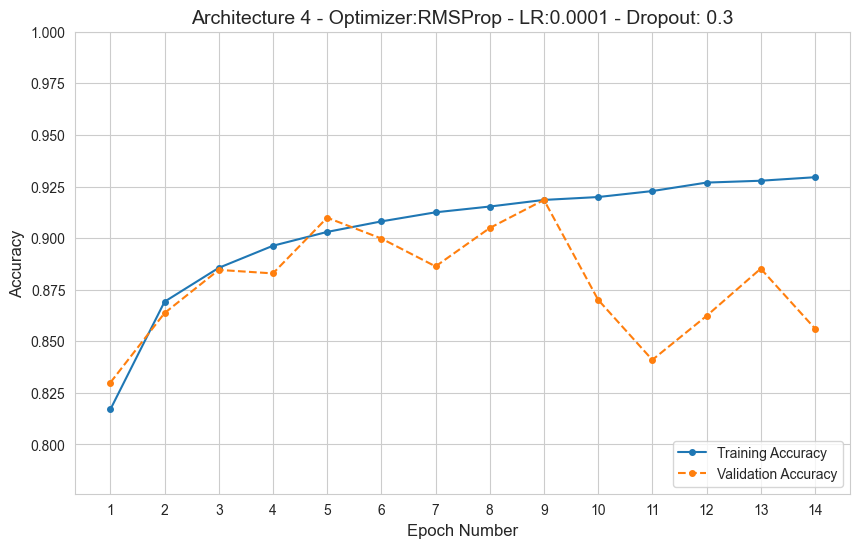

In [18]:
plot_arch_4()

### Confusion Matrix and Area Under Curve for Validation Data ##

As a final step in the analysis, I will generate predictions using the validation data and the trained model. The classification report confirms the **validation accurac of 92%**. The **Area Under Curve is 97%.**


In [30]:
#I need a new Validation Generator with shuffle=False so I can compare
#with true labels
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=SEED
)

validation_steps = validation_generator.samples // validation_generator.batch_size
if validation_generator.samples % validation_generator.batch_size != 0:
    validation_steps += 1

# Get the raw probability predictions for the validation set
y_pred_probs = full_model.predict(
    validation_generator,
    steps=validation_steps,
    verbose=1
)

Found 43084 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step


In [32]:

# Get the true labels from the validation generator
# .labels contains the true class indices (0s and 1s)
y_true = validation_generator.labels

In [34]:
#flatten and convert the predictions from probability to binary labels
y_pred_probs_flat = y_pred_probs.flatten()

y_pred_classes = (y_pred_probs_flat > 0.5).astype(int)

[[23871  1761]
 [ 1752 15700]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     25632
           1       0.90      0.90      0.90     17452

    accuracy                           0.92     43084
   macro avg       0.92      0.92      0.92     43084
weighted avg       0.92      0.92      0.92     43084



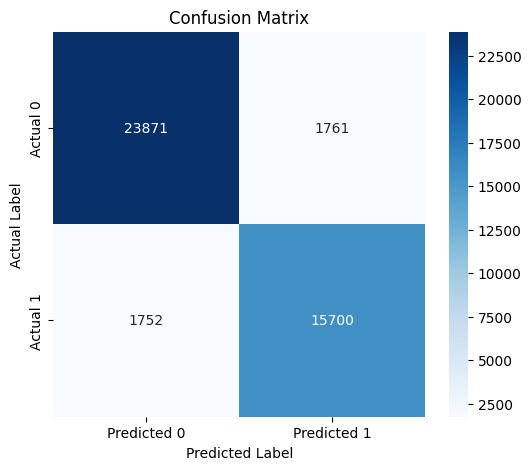

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y_true, y_pred_classes)

print(cm)

print(classification_report(y_true, y_pred_classes))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

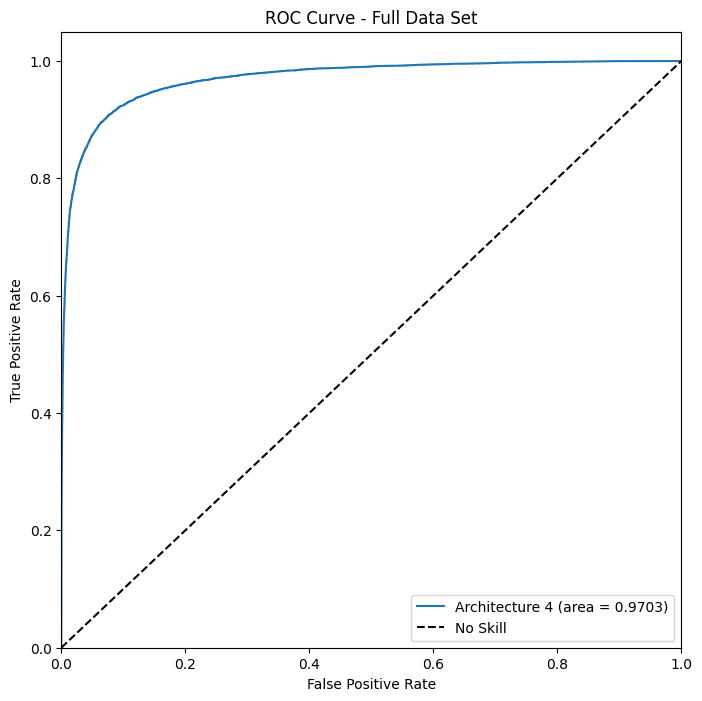

In [38]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs_flat)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='Architecture 4 (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Full Data Set')
plt.legend()
plt.show()

## Preparing Submission of Test Results to Kaggle ##
The following section generates predictions on the test data and formats the results for submission to Kaggle.

In [ ]:
import os

test_dir = '/content/data/test'
test_file_names = os.listdir(test_dir)

# Create a DataFrame for the generator
# It only needs the 'id' column for the generator to know which files to load
test_df = pd.DataFrame({'id': test_file_names})
print(test_df.head())

# Configure the Test Generator
test_datagen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    color_mode='rgb',
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=42
)



                                             id
0  7b868a07959d7c4c164f928c28ae7c74e61a6604.tif
1  2842ed2862f5c26f32896d09acc7ff5611f219b2.tif
2  b537b69496669600e6f9660c213283c1f9930a79.tif
3  b72457cac9627a7af39836a71655ec0f9bc46ee0.tif
4  75dde1bf60f4c244353f9daabfb849dfb2d311ac.tif
Found 57458 validated image filenames.


In [ ]:
# The steps value ensures the generator is run until all images are processed
steps = int(np.ceil(test_datagen.n / test_datagen.batch_size))
y_pred_proba = full_model.predict(test_datagen, steps=steps, verbose=1)

# Convert probabilities to binary labels (0 or 1) by rounding
y_pred_labels = (y_pred_proba > 0.5).astype(int).flatten()

file_names_with_ext = test_datagen.filenames

# Extract the submission ID (filename WITHOUT the .tif extension)
submission_ids = [os.path.splitext(f)[0] for f in file_names_with_ext]

submission_df = pd.DataFrame({
    'id': submission_ids,
    'label': y_pred_labels
})

submission_df.to_csv('/content/cancer_submission.csv', index=False)

print(submission_df.head())

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step
                                         id  label
0  7b868a07959d7c4c164f928c28ae7c74e61a6604      1
1  2842ed2862f5c26f32896d09acc7ff5611f219b2      0
2  b537b69496669600e6f9660c213283c1f9930a79      0
3  b72457cac9627a7af39836a71655ec0f9bc46ee0      0
4  75dde1bf60f4c244353f9daabfb849dfb2d311ac      0


# Discussion and Conclusion #

## Learnings and Takeaways ##
- Architecture 4 allowed me to achieve my goal of 90% or better validation accuracy.
- Models without a dropout layer resulted in significant overfitting
- Multi layer dense networks for classification resulted in significant overfitting
- Models and hyperparameters that performed well on a small subset of the data did not necessarily perform well on the entire data set.

## Things That Did Not Work as Expected ##

- Initial efforts to conduct hyperparameter search on the entire dataset were not fruitful (it took a very long time). So I moved to using a subset of the data for hyperparameter tuning.
- After tuning hyperparameters and finding a good architecture on a subset of the data, I found the results did not translate well to the entire data set. So I had to resume testing models and hyperparameters on the entire data set.
- I initially was not resetting the keras backend between runs during hyperparameter tuning. I started seeing inconsistent results, and, found the keras documentation recommends calling *tf.keras.backend.clear_session()* between training runs.

## Future Improvements ##
- My best training run on the full data set peaked at 92% training and validation accuracy and then started overfitting. I suspect that more aggressive regularization, dropouts, and other techniques to reduce overfitting might allow the training to continue for more epochs before overfitting and might result in overall higher accuracy.



# Citations #

- Baeldung. (2023). What is the purpose of a feature map in a convolutional neural network | Baeldung on computer science. https://www.baeldung.com/cs/cnn-feature-map
- Cukierski, W. (2018). Histopathologic Cancer detection. Kaggle. https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview
- Litjens, G. (2019, April 24). Getting started with Camelyon (Part 1). Geert Litjens. https://geertlitjens.nl/post/getting-started-with-camelyon/
- Minhas, M. S. (2025, March 5). Image data generators in Keras. Towards Data Science. https://towardsdatascience.com/image-data-generators-in-keras-7c5fc6928400/?gi=1ee1e52e7465
- More, P. (2025, September 2). Outlier detection with the IQR Method: A Complete Guide. Medium. https://medium.com/@morepravin1989/outlier-detection-with-the-iqr-method-a-complete-guide-c0199bbc10bd
- Veeling, B. (2018). Basveeling/PCAM: The Patchcamelyon (PCAM) deep learning classification benchmark. GitHub. https://github.com/basveeling/pcam




In [16]:
#figure generation support - graph from keras logs

import re
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

def generate_keras_graph(log_data, title):

    # Regular expression to find the epoch number (e.g., 'Epoch 1/50')
    epoch_pattern = re.compile(r'^Epoch (\d+)/\d+$')

    # Regular expression to find accuracy and val_accuracy on the metrics line
    metrics_pattern = re.compile(r'accuracy: (\d+\.\d+) .* val_accuracy: (\d+\.\d+)')

    data = []
    current_epoch = None

    # Process the log data line by line
    for line in StringIO(log_data):
        line_stripped = line.strip()

        epoch_match = epoch_pattern.search(line_stripped)
        if epoch_match:
            current_epoch = int(epoch_match.group(1))
            continue

        metrics_match = metrics_pattern.search(line_stripped)
        if metrics_match and current_epoch is not None:
            accuracy = float(metrics_match.group(1))
            val_accuracy = float(metrics_match.group(2))

            data.append({
                'accuracy': accuracy,
                'val_accuracy': val_accuracy
            })
            current_epoch = None

    df = pd.DataFrame(data)

    df['overall_epoch'] = df.index + 1

    plt.figure(figsize=(10, 6))
    plt.plot(df['overall_epoch'], df['accuracy'], label='Training Accuracy', marker='o', markersize=3, linestyle='-')
    plt.plot(df['overall_epoch'], df['val_accuracy'], label='Validation Accuracy', marker='o', markersize=3, linestyle='--')
    plt.title(title, fontsize=14)
    plt.xlabel('Epoch Number', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)
    tick_step = max(1, len(df) // 10)
    plt.xticks(df['overall_epoch'][::tick_step])
    plt.ylim(min(df[['accuracy', 'val_accuracy']].min()) * 0.95, 1.0)
    plt.show()


def plot_final_training_grpah(log_data, title):

    ansi_escape = re.compile(r'\x1b\[[0-9;]*m')
    epoch_pattern = re.compile(r'^Epoch (\d+)/\d+$')
    metrics_pattern = re.compile(r'accuracy: (\d+\.\d+) .* val_accuracy: (\d+\.\d+)')

    data = []
    current_epoch = None

    # Process the log data line by line
    for line in StringIO(log_data):
        clean_line = ansi_escape.sub('', line).strip()

        epoch_match = epoch_pattern.search(clean_line)
        if epoch_match:
            current_epoch = int(epoch_match.group(1))
            continue

        metrics_match = metrics_pattern.search(clean_line)
        if metrics_match and current_epoch is not None:
            accuracy = float(metrics_match.group(1))
            val_accuracy = float(metrics_match.group(2))

            data.append({
                'accuracy': accuracy,
                'val_accuracy': val_accuracy
            })
            current_epoch = None

    df = pd.DataFrame(data)

    df['epoch'] = df.index + 1

    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df['accuracy'], label='Training Accuracy', marker='o', markersize=4, linestyle='-')
    plt.plot(df['epoch'], df['val_accuracy'], label='Validation Accuracy', marker='o', markersize=4, linestyle='--')
    plt.title(title, fontsize=14)
    plt.xlabel('Epoch Number', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10, loc='lower right')
    plt.grid(True)
    plt.xticks(range(1, len(df) + 1))
    plt.ylim(min(df[['accuracy', 'val_accuracy']].min()) * 0.95, 1.0)
    plt.show()

In [2]:
def plot_arch_1():
    log_data = """Starting Hyperparameter Search on a training subset of 9721 images.
Running Trial: LR=0.0001, Opt=Adam, Epochs=50, dropout_rate=0.0
Epoch 1/50
152/152 - 13s - 86ms/step - accuracy: 0.6172 - loss: 0.6658 - val_accuracy: 0.7474 - val_loss: 0.6145
Epoch 2/50
152/152 - 1s - 7ms/step - accuracy: 0.7321 - loss: 0.5746 - val_accuracy: 0.7454 - val_loss: 0.5243
Epoch 3/50
152/152 - 1s - 7ms/step - accuracy: 0.7480 - loss: 0.5299 - val_accuracy: 0.7618 - val_loss: 0.5119
Epoch 4/50
152/152 - 1s - 7ms/step - accuracy: 0.7465 - loss: 0.5275 - val_accuracy: 0.7478 - val_loss: 0.5573
Epoch 5/50
152/152 - 1s - 7ms/step - accuracy: 0.7521 - loss: 0.5213 - val_accuracy: 0.7618 - val_loss: 0.5060
Epoch 6/50
152/152 - 1s - 7ms/step - accuracy: 0.7589 - loss: 0.5129 - val_accuracy: 0.7602 - val_loss: 0.5062
Epoch 7/50
152/152 - 1s - 7ms/step - accuracy: 0.7576 - loss: 0.5096 - val_accuracy: 0.7672 - val_loss: 0.5023
Epoch 8/50
152/152 - 1s - 7ms/step - accuracy: 0.7598 - loss: 0.5084 - val_accuracy: 0.7655 - val_loss: 0.5022
Epoch 9/50
152/152 - 1s - 7ms/step - accuracy: 0.7630 - loss: 0.5006 - val_accuracy: 0.7717 - val_loss: 0.4941
Epoch 10/50
152/152 - 1s - 7ms/step - accuracy: 0.7646 - loss: 0.4974 - val_accuracy: 0.7713 - val_loss: 0.4901
Epoch 11/50
152/152 - 1s - 7ms/step - accuracy: 0.7642 - loss: 0.4989 - val_accuracy: 0.7215 - val_loss: 0.5524
Epoch 12/50
152/152 - 1s - 7ms/step - accuracy: 0.7642 - loss: 0.4971 - val_accuracy: 0.7528 - val_loss: 0.5091
Epoch 13/50
152/152 - 1s - 7ms/step - accuracy: 0.7704 - loss: 0.4899 - val_accuracy: 0.7766 - val_loss: 0.4831
Epoch 14/50
152/152 - 1s - 7ms/step - accuracy: 0.7713 - loss: 0.4869 - val_accuracy: 0.7770 - val_loss: 0.4889
Epoch 15/50
152/152 - 1s - 7ms/step - accuracy: 0.7678 - loss: 0.4845 - val_accuracy: 0.7799 - val_loss: 0.4895
Epoch 16/50
152/152 - 1s - 7ms/step - accuracy: 0.7743 - loss: 0.4854 - val_accuracy: 0.7713 - val_loss: 0.4808
Epoch 17/50
152/152 - 1s - 7ms/step - accuracy: 0.7798 - loss: 0.4742 - val_accuracy: 0.7758 - val_loss: 0.4826
Epoch 18/50
152/152 - 1s - 7ms/step - accuracy: 0.7775 - loss: 0.4770 - val_accuracy: 0.7775 - val_loss: 0.4693
Epoch 19/50
152/152 - 1s - 7ms/step - accuracy: 0.7821 - loss: 0.4658 - val_accuracy: 0.7869 - val_loss: 0.4651
Epoch 20/50
152/152 - 1s - 7ms/step - accuracy: 0.7836 - loss: 0.4655 - val_accuracy: 0.7902 - val_loss: 0.4606
Epoch 21/50
152/152 - 1s - 7ms/step - accuracy: 0.7859 - loss: 0.4647 - val_accuracy: 0.7927 - val_loss: 0.4630
Epoch 22/50
152/152 - 1s - 7ms/step - accuracy: 0.7932 - loss: 0.4528 - val_accuracy: 0.7931 - val_loss: 0.4544
Epoch 23/50
152/152 - 1s - 7ms/step - accuracy: 0.7980 - loss: 0.4459 - val_accuracy: 0.7894 - val_loss: 0.4616
Epoch 24/50
152/152 - 1s - 7ms/step - accuracy: 0.7973 - loss: 0.4387 - val_accuracy: 0.7890 - val_loss: 0.4685
Epoch 25/50
152/152 - 1s - 7ms/step - accuracy: 0.8016 - loss: 0.4384 - val_accuracy: 0.7939 - val_loss: 0.4552
Epoch 26/50
152/152 - 1s - 7ms/step - accuracy: 0.8033 - loss: 0.4336 - val_accuracy: 0.7943 - val_loss: 0.4450
Epoch 27/50
152/152 - 1s - 7ms/step - accuracy: 0.8059 - loss: 0.4295 - val_accuracy: 0.7898 - val_loss: 0.4628
Epoch 28/50
152/152 - 1s - 7ms/step - accuracy: 0.8148 - loss: 0.4160 - val_accuracy: 0.7770 - val_loss: 0.4872
Epoch 29/50
152/152 - 1s - 7ms/step - accuracy: 0.8162 - loss: 0.4141 - val_accuracy: 0.7795 - val_loss: 0.4816
Epoch 30/50
152/152 - 1s - 7ms/step - accuracy: 0.8247 - loss: 0.4013 - val_accuracy: 0.7914 - val_loss: 0.4540
Epoch 31/50
152/152 - 1s - 7ms/step - accuracy: 0.8276 - loss: 0.3983 - val_accuracy: 0.7993 - val_loss: 0.4497
         0.0100   RMSProp      50  0.694738      0.491156
"""
    generate_keras_graph(log_data, 'Architecture 1 - Optimizer:Adam - LR:0.0001')

In [4]:
def plot_arch_2():
    log_data = """Starting Hyperparameter Search on a training subset of 9721 images.

Running Trial: LR=0.0001, Opt=Adam, Epochs=50, dropout_rate=0.0
Epoch 1/50
152/152 - 17s - 114ms/step - accuracy: 0.6625 - loss: 0.6307 - val_accuracy: 0.7820 - val_loss: 0.5033
Epoch 2/50
152/152 - 4s - 29ms/step - accuracy: 0.7681 - loss: 0.4959 - val_accuracy: 0.7635 - val_loss: 0.4811
Epoch 3/50
152/152 - 4s - 29ms/step - accuracy: 0.7784 - loss: 0.4819 - val_accuracy: 0.7371 - val_loss: 0.5072
Epoch 4/50
152/152 - 4s - 29ms/step - accuracy: 0.7855 - loss: 0.4708 - val_accuracy: 0.7717 - val_loss: 0.4729
Epoch 5/50
152/152 - 4s - 29ms/step - accuracy: 0.7937 - loss: 0.4558 - val_accuracy: 0.8050 - val_loss: 0.4372
Epoch 6/50
152/152 - 4s - 29ms/step - accuracy: 0.7964 - loss: 0.4481 - val_accuracy: 0.7980 - val_loss: 0.4595
Epoch 7/50
152/152 - 4s - 29ms/step - accuracy: 0.8026 - loss: 0.4420 - val_accuracy: 0.7840 - val_loss: 0.4446
Epoch 8/50
152/152 - 4s - 29ms/step - accuracy: 0.8071 - loss: 0.4327 - val_accuracy: 0.8058 - val_loss: 0.4210
Epoch 9/50
152/152 - 4s - 29ms/step - accuracy: 0.8153 - loss: 0.4177 - val_accuracy: 0.8141 - val_loss: 0.4069
Epoch 10/50
152/152 - 4s - 29ms/step - accuracy: 0.8200 - loss: 0.4122 - val_accuracy: 0.7680 - val_loss: 0.4824
Epoch 11/50
152/152 - 4s - 29ms/step - accuracy: 0.8221 - loss: 0.4024 - val_accuracy: 0.8108 - val_loss: 0.4118
Epoch 12/50
152/152 - 4s - 29ms/step - accuracy: 0.8170 - loss: 0.4075 - val_accuracy: 0.8153 - val_loss: 0.3914
Epoch 13/50
152/152 - 4s - 29ms/step - accuracy: 0.8260 - loss: 0.3966 - val_accuracy: 0.8079 - val_loss: 0.4060
Epoch 14/50
152/152 - 4s - 29ms/step - accuracy: 0.8377 - loss: 0.3767 - val_accuracy: 0.8289 - val_loss: 0.3690
Epoch 15/50
152/152 - 4s - 29ms/step - accuracy: 0.8367 - loss: 0.3693 - val_accuracy: 0.8396 - val_loss: 0.3646
Epoch 16/50
152/152 - 4s - 29ms/step - accuracy: 0.8374 - loss: 0.3727 - val_accuracy: 0.8120 - val_loss: 0.3874
Epoch 17/50
152/152 - 4s - 29ms/step - accuracy: 0.8395 - loss: 0.3626 - val_accuracy: 0.8466 - val_loss: 0.3520
Epoch 18/50
152/152 - 4s - 29ms/step - accuracy: 0.8435 - loss: 0.3576 - val_accuracy: 0.8445 - val_loss: 0.3727
Epoch 19/50
152/152 - 4s - 29ms/step - accuracy: 0.8459 - loss: 0.3522 - val_accuracy: 0.8429 - val_loss: 0.3463
Epoch 20/50
152/152 - 4s - 29ms/step - accuracy: 0.8491 - loss: 0.3439 - val_accuracy: 0.8470 - val_loss: 0.3395
Epoch 21/50
152/152 - 4s - 29ms/step - accuracy: 0.8483 - loss: 0.3404 - val_accuracy: 0.8260 - val_loss: 0.3741
Epoch 22/50
152/152 - 4s - 29ms/step - accuracy: 0.8566 - loss: 0.3330 - val_accuracy: 0.8507 - val_loss: 0.3395
Epoch 23/50
152/152 - 4s - 29ms/step - accuracy: 0.8615 - loss: 0.3204 - val_accuracy: 0.7964 - val_loss: 0.4164
Epoch 24/50
152/152 - 4s - 29ms/step - accuracy: 0.8579 - loss: 0.3305 - val_accuracy: 0.8445 - val_loss: 0.3456
Epoch 25/50
152/152 - 4s - 29ms/step - accuracy: 0.8631 - loss: 0.3163 - val_accuracy: 0.8416 - val_loss: 0.3461

"""

    generate_keras_graph(log_data, 'Architecture 2 - Optimizer:Adam - LR:0.0001')

In [5]:
def plot_arch_3():
    log_data = """Starting Hyperparameter Search on a training subset of 9721 images.

Running Trial: LR=0.0001, Opt=Adam, Epochs=50, dropout_rate=0.4
Epoch 1/50
152/152 - 27s - 181ms/step - accuracy: 0.7346 - loss: 0.5448 - val_accuracy: 0.5093 - val_loss: 0.9761
Epoch 2/50
152/152 - 5s - 34ms/step - accuracy: 0.8012 - loss: 0.4487 - val_accuracy: 0.5627 - val_loss: 2.1508
Epoch 3/50
152/152 - 5s - 33ms/step - accuracy: 0.8212 - loss: 0.4212 - val_accuracy: 0.5944 - val_loss: 2.0674
Epoch 4/50
152/152 - 5s - 34ms/step - accuracy: 0.8329 - loss: 0.3962 - val_accuracy: 0.6713 - val_loss: 0.9808
Epoch 5/50
152/152 - 5s - 34ms/step - accuracy: 0.8342 - loss: 0.3887 - val_accuracy: 0.8285 - val_loss: 0.4012
Epoch 6/50
152/152 - 5s - 34ms/step - accuracy: 0.8433 - loss: 0.3760 - val_accuracy: 0.8030 - val_loss: 0.4585
Epoch 7/50
152/152 - 5s - 34ms/step - accuracy: 0.8489 - loss: 0.3680 - val_accuracy: 0.8132 - val_loss: 0.4487
Epoch 8/50
152/152 - 5s - 34ms/step - accuracy: 0.8534 - loss: 0.3612 - val_accuracy: 0.8573 - val_loss: 0.3225
Epoch 9/50
152/152 - 5s - 34ms/step - accuracy: 0.8573 - loss: 0.3409 - val_accuracy: 0.8573 - val_loss: 0.3542
Epoch 10/50
152/152 - 5s - 34ms/step - accuracy: 0.8558 - loss: 0.3425 - val_accuracy: 0.8659 - val_loss: 0.3122
Epoch 11/50
152/152 - 5s - 34ms/step - accuracy: 0.8612 - loss: 0.3365 - val_accuracy: 0.8589 - val_loss: 0.3334
Epoch 12/50
152/152 - 5s - 34ms/step - accuracy: 0.8610 - loss: 0.3313 - val_accuracy: 0.8305 - val_loss: 0.4259
Epoch 13/50
152/152 - 5s - 33ms/step - accuracy: 0.8667 - loss: 0.3216 - val_accuracy: 0.8392 - val_loss: 0.3872
Epoch 14/50
152/152 - 5s - 34ms/step - accuracy: 0.8649 - loss: 0.3274 - val_accuracy: 0.8350 - val_loss: 0.3688
Epoch 15/50
152/152 - 5s - 34ms/step - accuracy: 0.8680 - loss: 0.3171 - val_accuracy: 0.8737 - val_loss: 0.3134

"""
    generate_keras_graph(log_data, 'Architecture 3 - Optimizer:Adam - LR:0.0001 - Dropout: 0.4')

In [11]:
def plot_arch_3_overfitting():
    log_data = """
Running Trial: LR=0.001, Opt=RMSProp, Epochs=50, dropout_rate=0.3
Epoch 1/50
152/152 - 25s - 165ms/step - accuracy: 0.7900 - loss: 0.4663 - val_accuracy: 0.5878 - val_loss: 2.9797
Epoch 2/50
152/152 - 5s - 33ms/step - accuracy: 0.8330 - loss: 0.3885 - val_accuracy: 0.6355 - val_loss: 1.0269
Epoch 3/50
152/152 - 5s - 33ms/step - accuracy: 0.8483 - loss: 0.3661 - val_accuracy: 0.7651 - val_loss: 0.5376
Epoch 4/50
152/152 - 5s - 33ms/step - accuracy: 0.8600 - loss: 0.3408 - val_accuracy: 0.8186 - val_loss: 0.5298
Epoch 5/50
152/152 - 5s - 33ms/step - accuracy: 0.8689 - loss: 0.3148 - val_accuracy: 0.8552 - val_loss: 0.3780
Epoch 6/50
152/152 - 5s - 33ms/step - accuracy: 0.8782 - loss: 0.2989 - val_accuracy: 0.8667 - val_loss: 0.3759
Epoch 7/50
152/152 - 5s - 34ms/step - accuracy: 0.8836 - loss: 0.2892 - val_accuracy: 0.8840 - val_loss: 0.2982
Epoch 8/50
152/152 - 5s - 33ms/step - accuracy: 0.8903 - loss: 0.2699 - val_accuracy: 0.8190 - val_loss: 0.5005
Epoch 9/50
152/152 - 5s - 33ms/step - accuracy: 0.8963 - loss: 0.2665 - val_accuracy: 0.8819 - val_loss: 0.2715
Epoch 10/50
152/152 - 5s - 33ms/step - accuracy: 0.9008 - loss: 0.2548 - val_accuracy: 0.6652 - val_loss: 1.1338
Epoch 11/50
152/152 - 5s - 33ms/step - accuracy: 0.9053 - loss: 0.2414 - val_accuracy: 0.8898 - val_loss: 0.2882
Epoch 12/50
152/152 - 5s - 33ms/step - accuracy: 0.9106 - loss: 0.2334 - val_accuracy: 0.7067 - val_loss: 0.7380
Epoch 13/50
152/152 - 5s - 33ms/step - accuracy: 0.9152 - loss: 0.2213 - val_accuracy: 0.9009 - val_loss: 0.2550
Epoch 14/50
152/152 - 5s - 33ms/step - accuracy: 0.9166 - loss: 0.2131 - val_accuracy: 0.6516 - val_loss: 1.7220
Epoch 15/50
152/152 - 5s - 33ms/step - accuracy: 0.9216 - loss: 0.2060 - val_accuracy: 0.8638 - val_loss: 0.4179
Epoch 16/50
152/152 - 5s - 33ms/step - accuracy: 0.9256 - loss: 0.1960 - val_accuracy: 0.7639 - val_loss: 1.1888
Epoch 17/50
152/152 - 5s - 33ms/step - accuracy: 0.9295 - loss: 0.1886 - val_accuracy: 0.7931 - val_loss: 1.0046
Epoch 18/50
152/152 - 5s - 33ms/step - accuracy: 0.9357 - loss: 0.1734 - val_accuracy: 0.6495 - val_loss: 1.6515
"""

    generate_keras_graph(log_data, 'Architecture 3a - Optimizer:RMSProp - LR:0.001 - Dropout: 0.3')


In [13]:
def plot_arch_3_a():
    log_data = """
Running Trial: LR=0.0001, Opt=RMSProp, Epochs=50, dropout_rate=0.2
Epoch 1/50
152/152 - 25s - 166ms/step - accuracy: 0.7857 - loss: 0.4658 - val_accuracy: 0.6100 - val_loss: 0.7325
Epoch 2/50
152/152 - 5s - 33ms/step - accuracy: 0.8155 - loss: 0.4203 - val_accuracy: 0.5965 - val_loss: 1.2630
Epoch 3/50
152/152 - 5s - 33ms/step - accuracy: 0.8341 - loss: 0.3854 - val_accuracy: 0.6421 - val_loss: 1.2120
Epoch 4/50
152/152 - 5s - 33ms/step - accuracy: 0.8421 - loss: 0.3718 - val_accuracy: 0.7639 - val_loss: 0.5833
Epoch 5/50
152/152 - 5s - 33ms/step - accuracy: 0.8451 - loss: 0.3607 - val_accuracy: 0.8404 - val_loss: 0.3646
Epoch 6/50
152/152 - 5s - 33ms/step - accuracy: 0.8564 - loss: 0.3452 - val_accuracy: 0.8017 - val_loss: 0.4731
Epoch 7/50
152/152 - 5s - 34ms/step - accuracy: 0.8527 - loss: 0.3416 - val_accuracy: 0.8597 - val_loss: 0.3273
Epoch 8/50
152/152 - 5s - 33ms/step - accuracy: 0.8593 - loss: 0.3293 - val_accuracy: 0.7984 - val_loss: 0.5295
Epoch 9/50
152/152 - 5s - 34ms/step - accuracy: 0.8631 - loss: 0.3289 - val_accuracy: 0.8671 - val_loss: 0.3204
Epoch 10/50
152/152 - 5s - 33ms/step - accuracy: 0.8701 - loss: 0.3130 - val_accuracy: 0.8647 - val_loss: 0.3381
Epoch 11/50
152/152 - 5s - 33ms/step - accuracy: 0.8750 - loss: 0.2985 - val_accuracy: 0.8453 - val_loss: 0.3991
Epoch 12/50
152/152 - 5s - 33ms/step - accuracy: 0.8748 - loss: 0.3016 - val_accuracy: 0.8737 - val_loss: 0.2880
Epoch 13/50
152/152 - 5s - 33ms/step - accuracy: 0.8804 - loss: 0.2913 - val_accuracy: 0.8700 - val_loss: 0.3335
Epoch 14/50
152/152 - 5s - 33ms/step - accuracy: 0.8793 - loss: 0.2875 - val_accuracy: 0.8519 - val_loss: 0.3341
Epoch 15/50
152/152 - 5s - 33ms/step - accuracy: 0.8817 - loss: 0.2823 - val_accuracy: 0.8782 - val_loss: 0.3131
Epoch 16/50
152/152 - 5s - 33ms/step - accuracy: 0.8878 - loss: 0.2754 - val_accuracy: 0.8235 - val_loss: 0.4114
Epoch 17/50
152/152 - 5s - 33ms/step - accuracy: 0.8922 - loss: 0.2650 - val_accuracy: 0.8404 - val_loss: 0.3773

"""

    generate_keras_graph(log_data, 'Architecture 3 - Optimizer:RMSProp - LR:0.0001 - Dropout: 0.2')


In [17]:
def plot_arch_4():
    log_data = """
    Epoch 1/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m416s[0m 186ms/step - accuracy: 0.8170 - loss: 0.4201 - val_accuracy: 0.8300 - val_loss: 0.4421
Epoch 2/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m396s[0m 181ms/step - accuracy: 0.8692 - loss: 0.3173 - val_accuracy: 0.8637 - val_loss: 0.3385
Epoch 3/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m398s[0m 182ms/step - accuracy: 0.8856 - loss: 0.2834 - val_accuracy: 0.8846 - val_loss: 0.3191
Epoch 4/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m400s[0m 183ms/step - accuracy: 0.8963 - loss: 0.2643 - val_accuracy: 0.8829 - val_loss: 0.2979
Epoch 5/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m396s[0m 181ms/step - accuracy: 0.9030 - loss: 0.2470 - val_accuracy: 0.9099 - val_loss: 0.2326
Epoch 6/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m399s[0m 183ms/step - accuracy: 0.9081 - loss: 0.2378 - val_accuracy: 0.8998 - val_loss: 0.2635
Epoch 7/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m400s[0m 183ms/step - accuracy: 0.9125 - loss: 0.2307 - val_accuracy: 0.8863 - val_loss: 0.3066
Epoch 8/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m399s[0m 183ms/step - accuracy: 0.9153 - loss: 0.2226 - val_accuracy: 0.9049 - val_loss: 0.2681
Epoch 9/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m400s[0m 183ms/step - accuracy: 0.9185 - loss: 0.2137 - val_accuracy: 0.9185 - val_loss: 0.2239
Epoch 10/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m398s[0m 182ms/step - accuracy: 0.9199 - loss: 0.2107 - val_accuracy: 0.8701 - val_loss: 0.3577
Epoch 11/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m397s[0m 182ms/step - accuracy: 0.9228 - loss: 0.2040 - val_accuracy: 0.8410 - val_loss: 0.4815
Epoch 12/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m397s[0m 182ms/step - accuracy: 0.9269 - loss: 0.1967 - val_accuracy: 0.8623 - val_loss: 0.3487
Epoch 13/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m396s[0m 182ms/step - accuracy: 0.9278 - loss: 0.1944 - val_accuracy: 0.8852 - val_loss: 0.3144
Epoch 14/50
[1m2182/2182[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m398s[0m 182ms/step - accuracy: 0.9295 - loss: 0.1899 - val_accuracy: 0.8562 - val_loss: 0.3998

    """
    plot_final_training_grpah(log_data, 'Architecture 4 - Optimizer:RMSProp - LR:0.0001 - Dropout: 0.3')